In [ ]:
!pip install tokenizers
!pip install tqdm boto3 requests regex sentencepiece sacremoses
!pip install sentencepiece
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 29.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 877.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 27.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 25.8 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=8e10763ee7912d8e55b0f28cbbc65e7adac3163498b989215d3306aa7f66a456
  Stored in directory: /root/.cache/pip/wheels/12/1c/3d/46cf06718d63a32ff798a89594b61e7f345ab6b36d909ce033
Successfully 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from google.colab import drive
import random
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score
import time
from sklearn.model_selection import GridSearchCV
import os
import re
import torch
# Load pre-trained BERT model and tokenizer
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import time

### Code to load the data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Temporary load data meachanism since the normal way takes way too long

raw_train_data, raw_test_data = pd.read_csv("/content/drive/MyDrive/COMP_551/A3/aclImdb/train_data.csv").drop('Unnamed: 0', axis=1), pd.read_csv("/content/drive/MyDrive/COMP_551/A3/aclImdb/test_data.csv").drop('Unnamed: 0', axis=1)

In [ ]:
raw_train_data = raw_train_data.iloc[:250, :] # Artificially reducing the training data size here
raw_test_data = raw_test_data.iloc[:1000, :] # Artificially reducing the test data size here

### Code to preprocess and tokenize the data

In [ ]:
# preprocessing

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

raw_train_data['text'] = raw_train_data['text'].apply(preprocess_text)
raw_test_data['text'] = raw_test_data['text'].apply(preprocess_text)

In [ ]:
# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
def tokenizer_function(input_sequence):
    
    encoded_dict = tokenizer.encode_plus(
        input_sequence,
        add_special_tokens=True,
        max_length=510,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation='longest_first'
    )

    return encoded_dict
    # train_input_ids.append(encoded_dict['input_ids'])
    # train_attention_masks.append(encoded_dict['attention_mask'])


def extract_input_id(encoded_dict):
  return encoded_dict['input_ids']
def extract_attention_mask(encoded_dict):
  return encoded_dict['attention_mask']

  



In [ ]:
# tokenizing and establishing attention masks for each of the input_texts in the test data

raw_test_data['encoded_dict'] = raw_test_data['text'].apply(tokenizer_function) 
raw_test_data['input_ids'] = raw_test_data['encoded_dict'].apply(extract_input_id)
raw_test_data['attention_mask'] = raw_test_data['encoded_dict'].apply(extract_attention_mask)
test_input_ids = torch.cat(list(raw_test_data['input_ids']), dim=0)
test_attention_masks = torch.cat(list(raw_test_data['attention_mask']), dim=0)
test_labels = torch.tensor(list(raw_test_data['sentiment']))

In [ ]:
# Create a TensorDataset object from the test data
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# Create a DataLoader object from the test dataset
test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=2,
    drop_last=True
)


### Loading the model trained in the BERT Train Notebook

In [ ]:
# Load the saved model state dictionary
state_dict = torch.load( '/content/drive/MyDrive/COMP_551/A3/aclImdb/model.pth')

# Load the pre-trained BERT model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Add the previously defined head
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(in_features=model.config.hidden_size, out_features=2)
)

# Load the saved model state dictionary into the model
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### Evaluating the model on the test data

In [ ]:
# Evaluate the model on test data
total_correct=0
with torch.no_grad():
    correctly_predicted_positive_attentions=[]
    correctly_predicted_negative_attentions=[]
    incorrectly_predicted_postive_attentions=[]
    incorrectly_predicted_negative_attentions=[]

    arr1_size_p=0
    arr1_size_n=0
    arr2_size_p=0
    arr2_size_n=0
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
        predictions = torch.argmax(outputs.logits, dim=1)

        accuracy = (predictions == labels).float().mean()
        
        if accuracy==1 and arr1_size_p!=2 and labels==1 and len(input_ids)<=30:
          correctly_predicted_positive_attentions.append((outputs.attentions[0][0], input_ids)) # [block_index][head_index]
          arr1_size_p+=1

        if accuracy==1 and arr1_size_n!=2 and labels==0 and len(input_ids)<=30:
          correctly_predicted_negative_attentions.append((outputs.attentions[0][0], input_ids)) # [block_index][head_index]
          arr1_size_n+=1

        if accuracy==0 and arr2_size_p!=2 and len(input_ids)<=30:
          incorrectly_predicted_postive_attentions.append((outputs.attentions[0][0], input_ids)) # [block /_index][head_index]
          arr2_size_p+=1

        if accuracy==0 and arr2_size_n!=2 and len(input_ids)<=30:
          incorrectly_predicted_negative_attentions.append((outputs.attentions[0][0], input_ids)) # [block /_index][head_index]
          arr2_size_n+=1
        
        
        total_correct+=accuracy

### Accuracy

In [ ]:
total_correct/1000

tensor(0.9060)

### Attention scores

#### Attention scores of some correctly predicted positive sentences


In [ ]:
def visualize_attention(att_mat, sentence):
    non_zero_ids = [i for i, x in enumerate(sentence) if x == 0 or x!=0]
    att_mat = att_mat[0, non_zero_ids][:, non_zero_ids][0]
    sentence = [x for x in sentence if x != 0]

    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Create an array of values
    arr = att_mat

    # Reshape the array to have only one row
    arr_row = arr.reshape((1, -1))

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(20, 1))
    sns.heatmap(arr_row, cmap='BuGn', ax=ax, annot=False, fmt='.2f', cbar=True, cbar_kws={'label': 'Attention Score'}, xticklabels=sentence)
    ax.set_title('Attention Scores wtr to class token')
    ax.set_xlabel('Word Index') # ASK: This is fine, right?
    ax.set_xticklabels(tokens, rotation=90)
    plt.show()


# attention = correctly_predicted_attentions[0][0]
# input_ids = correctly_predicted_attentions[0][1][0]
# input_ids = np.array(input_ids)
# attention = attention.cpu().numpy()
# att_mat=visualize_attention(att_mat=attention, sentence=input_ids)

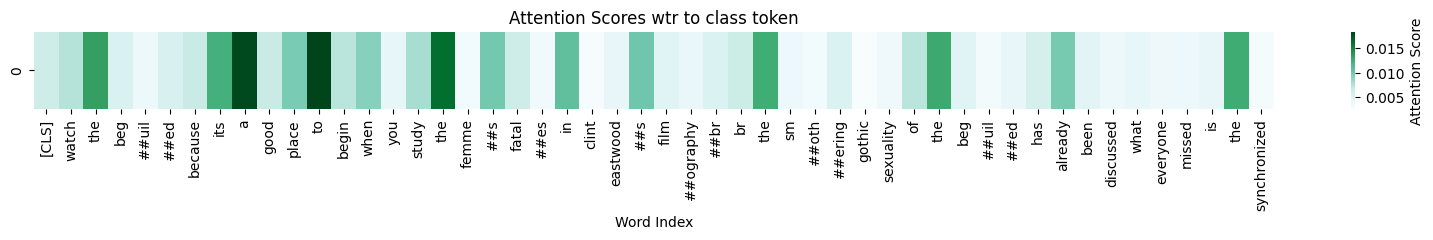

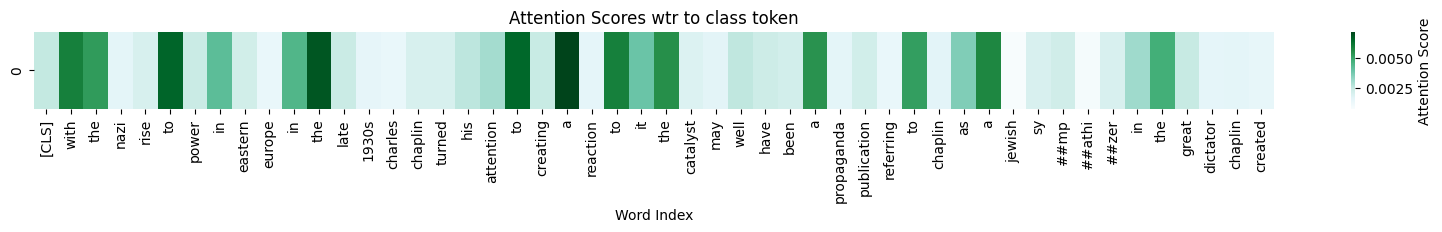

In [ ]:
# Attention scores of some correctly predicted positive sentences

for i in range(len(correctly_predicted_positive_attentions)):
  attention = correctly_predicted_positive_attentions[i][0][:50]
  input_ids = correctly_predicted_positive_attentions[i][1][0][:50]
  input_ids = np.array(input_ids)
  attention = attention.cpu().numpy()
  att_mat=visualize_attention(att_mat=attention, sentence=input_ids)

#### Attention scores of some correctly predicted negative sentences


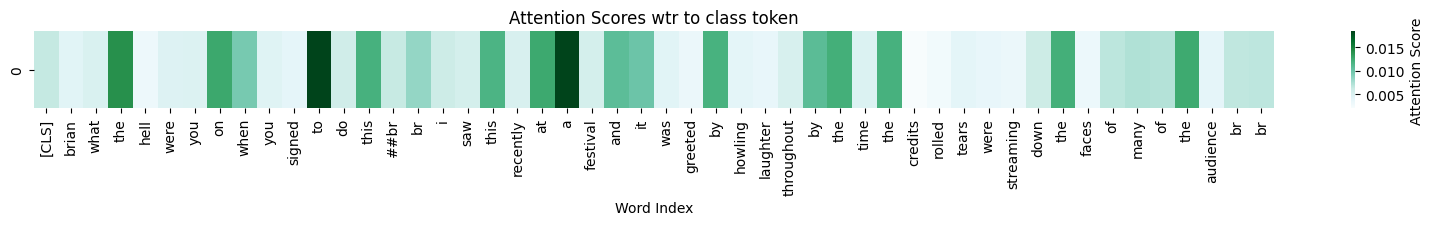

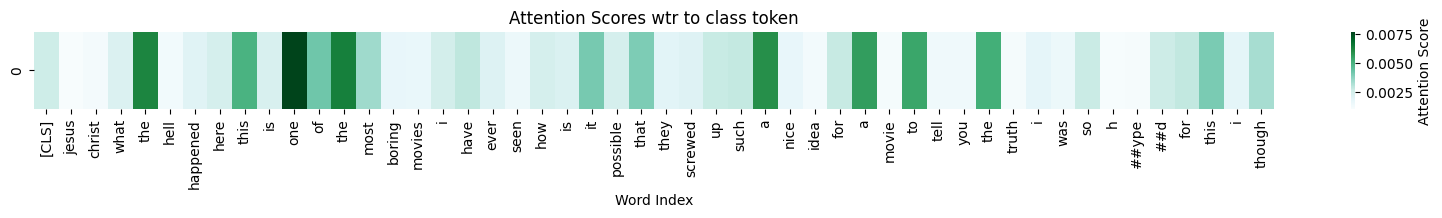

In [ ]:
# Attention scores of some correctly predicted negative sentences

for i in range(len(correctly_predicted_negative_attentions)):
  attention = correctly_predicted_negative_attentions[i][0][:50]
  input_ids = correctly_predicted_negative_attentions[i][1][0][:50]
  input_ids = np.array(input_ids)
  attention = attention.cpu().numpy()
  att_mat=visualize_attention(att_mat=attention, sentence=input_ids)

#### Attention scores of some incorrectly predicted positive sentences


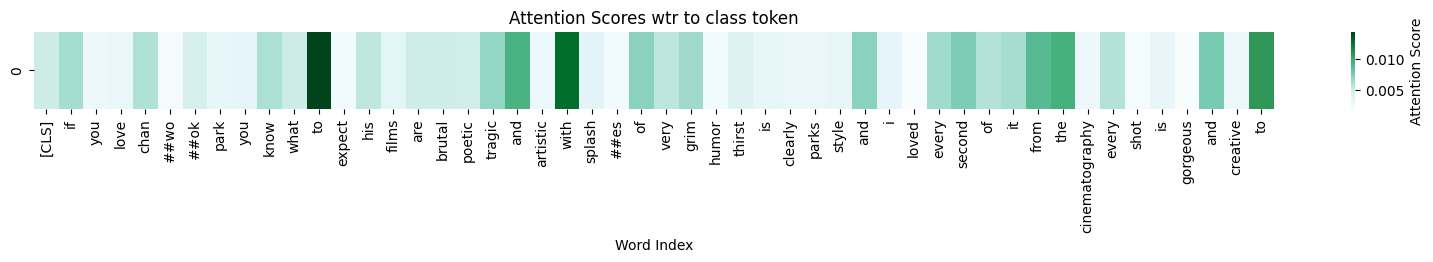

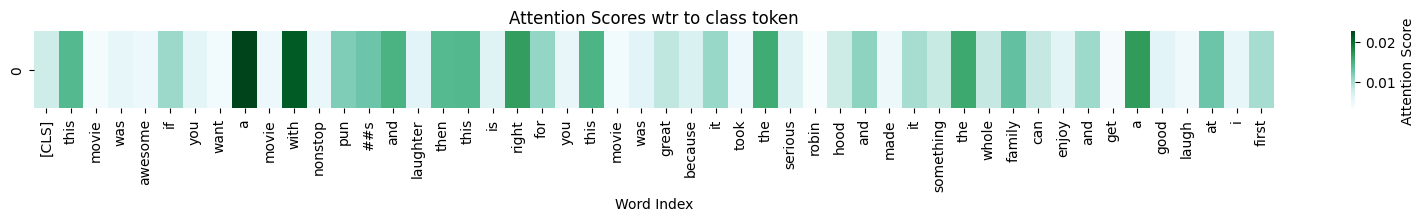

In [ ]:
# Attention scores of some incorrectly predicted positive sentences

for i in range(len(incorrectly_predicted_postive_attentions)):
  attention = incorrectly_predicted_postive_attentions[i][0][:50]
  input_ids = incorrectly_predicted_postive_attentions[i][1][0][:50]
  input_ids = np.array(input_ids)
  attention = attention.cpu().numpy()
  att_mat=visualize_attention(att_mat=attention, sentence=input_ids)

#### Attention scores of some incorrectly predicted negative sentences


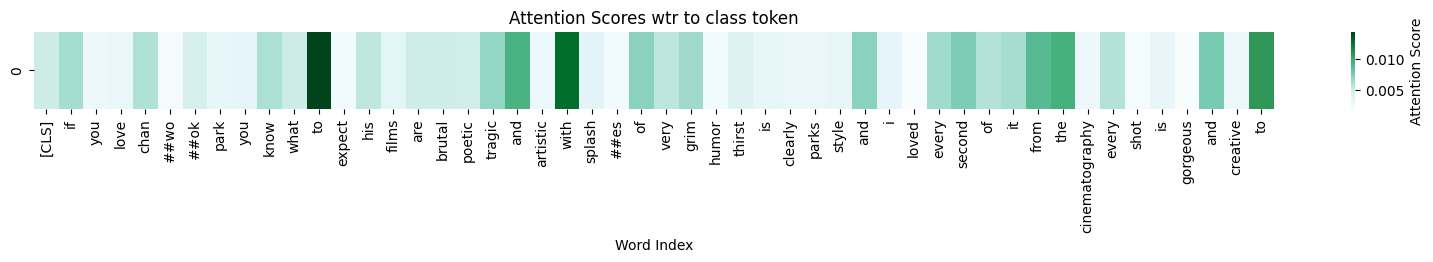

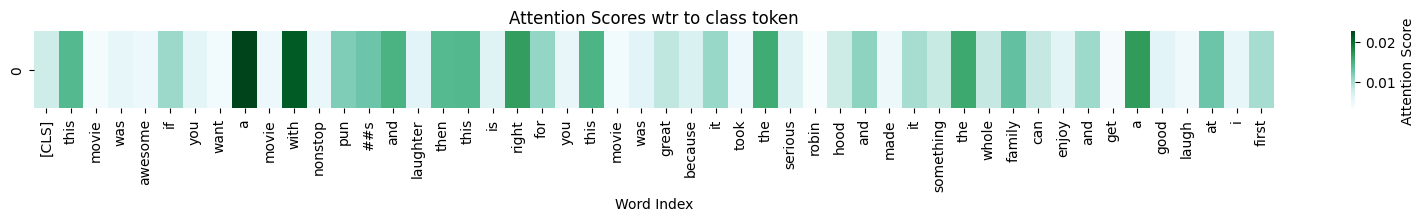

In [ ]:
# Attention scores of some incorrectly predicted negative sentences

for i in range(len(incorrectly_predicted_negative_attentions)):
  attention = incorrectly_predicted_negative_attentions[i][0][:50]
  input_ids = incorrectly_predicted_negative_attentions[i][1][0][:50]
  input_ids = np.array(input_ids)
  attention = attention.cpu().numpy()
  att_mat=visualize_attention(att_mat=attention, sentence=input_ids)